<h1>Predicting Hydration Free Energy of Organic molecules in water from their Molecular Structure</h1>

In this project, the <em><b>Hydration Free Energy</b></em> of a samll Organic Molecule is estimated from features derived from the Graph-representation of its molecular structure with a Deep Learning Model (Graph Neural Net.). 
<br>
To train and validate the model, we make use of the <a href="https://moleculenet.org/datasets-1">FreeSolv Dataset</a> - which comprises of <em>642</em> common organic molecules. In this small dataset, each molecule's structure is represented by its respective <b>SMILES</b> string. <em><b>Hydration Free Energy</b></em> is the amount of energy released when one mole of ions undergoes hydration is a <b><em>physical property</em></b> - not requiring assessment of any of its molecular chemical properties, hence information of the relative molecular conformers is not necessary i.e. 3D coordinates of molecular components.

In [1]:
import sys
from rdkit import Chem
import torch
import torch.nn.functional as F

from torch_geometric.nn import GCNConv, TopKPooling
from torch_geometric.nn import global_mean_pool as gap
from torch_geometric.nn import global_max_pool as gmp
from torch_geometric.datasets import MoleculeNet
from torch_geometric.data import DataLoader

import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

import warnings

sys.path.append("./gnns/")
from baseFreeSolvModel import baseFreeSolvModel
from freeSolveModel import freeSolveModel

C:\Users\palin\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


<h1>Inspect & Preview the Dataset</h1>

In [2]:
# Load the 'ESOL' component of the dataset
data = MoleculeNet(root='.', name="FreeSolv")
data

FreeSolv(642)

In [3]:
# inspect the dataset
print("Inspecting the dataset...\nDataset Type: {}\nNumber of features per molecule: {} | Number of Classes: {}\nNumber of Datapoints: {}".format(type(data), data.num_features, data.num_classes, data.len))

# inspecting a sample of the dataset
print("Inspecting a Molecule Graph data sample..\nFirst Molecule Graph Data in dataset: {}\nNumber of Nodes in Molecule Graph: {} | Number of Edges in Molecule Graph: {}".format(data[0], data[0].num_nodes, data[0].num_edges))
print("\nInspect the features in the data sample:")
display(data[0].x)
print("\nThe target variable for the Graph Data sample:")
display(data[0].y)
# print(data[0].edge_index.t()) # Get the Edge Insformation i.e. tuple of nodes connected by an edge.
print("The graph data has 13 nodes & each node is comprised of Node-features which consists of a tensor of 9 features for each node.")

Inspecting the dataset...
Dataset Type: <class 'torch_geometric.datasets.molecule_net.MoleculeNet'>
Number of features per molecule: 9 | Number of Classes: 485
Number of Datapoints: <bound method InMemoryDataset.len of FreeSolv(642)>
Inspecting a Molecule Graph data sample..
First Molecule Graph Data in dataset: Data(x=[13, 9], edge_index=[2, 26], edge_attr=[26, 3], y=[1, 1], smiles='CN(C)C(=O)c1ccc(cc1)OC')
Number of Nodes in Molecule Graph: 13 | Number of Edges in Molecule Graph: 26

Inspect the features in the data sample:


tensor([[6, 0, 4, 5, 3, 0, 4, 0, 0],
        [7, 0, 3, 5, 0, 0, 3, 0, 0],
        [6, 0, 4, 5, 3, 0, 4, 0, 0],
        [6, 0, 3, 5, 0, 0, 3, 0, 0],
        [8, 0, 1, 5, 0, 0, 3, 0, 0],
        [6, 0, 3, 5, 0, 0, 3, 1, 1],
        [6, 0, 3, 5, 1, 0, 3, 1, 1],
        [6, 0, 3, 5, 1, 0, 3, 1, 1],
        [6, 0, 3, 5, 0, 0, 3, 1, 1],
        [6, 0, 3, 5, 1, 0, 3, 1, 1],
        [6, 0, 3, 5, 1, 0, 3, 1, 1],
        [8, 0, 2, 5, 0, 0, 3, 0, 0],
        [6, 0, 4, 5, 3, 0, 4, 0, 0]])


The target variable for the Graph Data sample:


tensor([[-11.0100]])

The graph data has 13 nodes & each node is comprised of Node-features which consists of a tensor of 9 features for each node.


<h3>Visualize Molecules for a small sample of molecules in the dataset</h3>

Molecule SMILES string:  CN(C)C(=O)c1ccc(cc1)OC


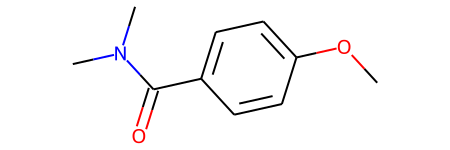

---------------------------------------------
Molecule SMILES string:  CS(=O)(=O)Cl


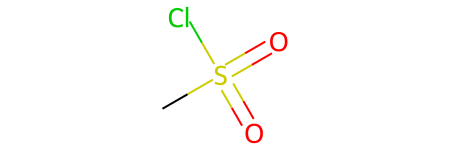

---------------------------------------------
Molecule SMILES string:  CC(C)C=C


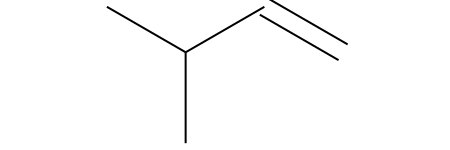

---------------------------------------------
Molecule SMILES string:  CCc1cnccn1


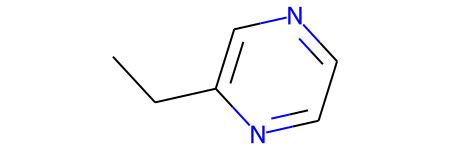

---------------------------------------------
Molecule SMILES string:  CCCCCCCO


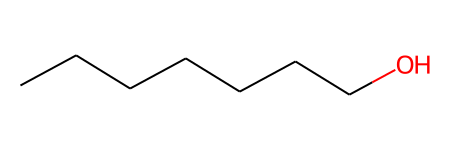

---------------------------------------------
Molecule SMILES string:  Cc1cc(cc(c1)O)C


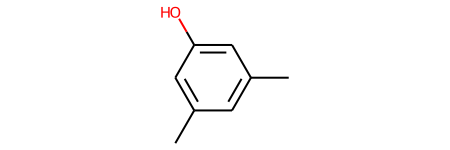

---------------------------------------------
Molecule SMILES string:  CC(C)C(C)C


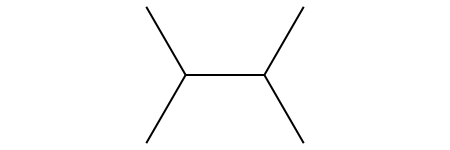

---------------------------------------------
Molecule SMILES string:  CCCC(C)(C)O


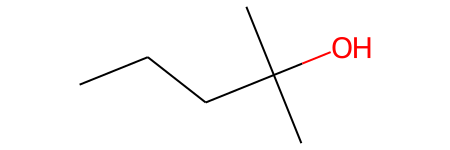

---------------------------------------------
Molecule SMILES string:  C[C@@H]1CCCC[C@@H]1C


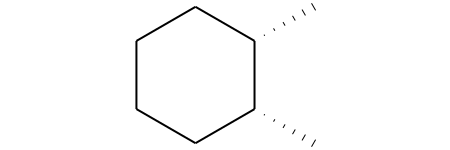

---------------------------------------------
Molecule SMILES string:  CC[C@H](C)O


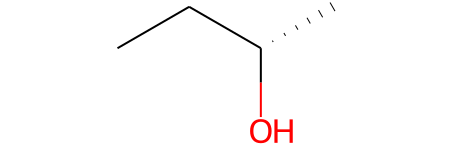

---------------------------------------------


In [4]:
# Visualizing Molecules
# Use RDKit to visualize molecular features of first 10 graph data samples

for i in range(10):
    molecule = Chem.MolFromSmiles(data[i]['smiles'])
    print("Molecule SMILES string: ", data[i]['smiles'])
    display(molecule)
    print('---------------------------------------------')

<hr style="border: 4px double orange;"></hr>
<h3>Baseline Predictive Model with Deep Graph Neural Nets</h3>

Create a baseline Model to benchmark the performance, on top of which a refined GNN model can be built to obtain improved predictions on <em>Hydration Free Energy</em>.
<br>
Upon inspecting the dataset - The target variable comprises of a single real (<em>float</em>) value - which indicates this as a <b><em>graph-level prediction problem</em></b>.

In [5]:
# Embedding size for each Graph NN layer
emb_size = 128

# Instantiating the Base Model
baseModel = baseFreeSolvModel(data.num_features, emb_size)

display(baseModel)

baseFreeSolvModel(
  (in_conv): GCNConv(9, 128)
  (conv1): GCNConv(128, 128)
  (conv2): GCNConv(128, 128)
  (conv3): GCNConv(128, 128)
  (conv4): GCNConv(128, 128)
  (out): Linear(in_features=256, out_features=1, bias=True)
)

In [6]:
# Summarize the instantiated Base Model
print("Number of Model Parameters: ", sum(p.numel() for p in baseModel.parameters()))

Number of Model Parameters:  67585


<h4>Compile the <em>baseline</em> model & define the Loss & Optimisation functions</h4>

In [7]:
# Use the GPU for Model training if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
baseModel = baseModel.to(device)

# Define the Objective Function for Base Model compilation
# MSE -> Objective / Loss Funciton
loss_function = torch.nn.MSELoss()
optimizer = torch.optim.RMSprop(baseModel.parameters(), lr = 0.0001, momentum=0.9)

# Use Data Loader to collate Data into batches
data_size = len(data)
batch_size = 64

# Pass 70% of the data as Train to the Data Loader
train_data_loader = DataLoader(data[:int(data_size * 0.80)], batch_size=batch_size, shuffle=True)

# Pass 20% of the data as Test to the Data Loader
test_data_loader = DataLoader(data[int(data_size * 0.80):], batch_size=batch_size, shuffle=True)

def model_train(train_data_loader=train_data_loader):
    
    for batch_data in train_data_loader:
        
        batch_data=batch_data.to(device)
        optimizer.zero_grad()
        prediction, embedding = baseModel(batch_data.x.float(), batch_data.edge_index, batch_data.batch)
        loss_val = loss_function(prediction, batch_data.y)
        loss_val.backward()
        optimizer.step()
    return loss_val, embedding

C:\Users\palin\Anaconda3\lib\site-packages\torch_geometric\deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


<hr style="border: 2px double gray"></hr>
<h3>Train the Baseline Model</h3>

In [8]:
epochs = 1500
hist_loss = []

for epoch in range(epochs):
    loss, h = model_train(train_data_loader)
    hist_loss.append(loss)
    if epoch%50 == 0:
        print("Completed Epochs: {} -> Loss: {}".format(epoch, loss))

C:\Users\palin\Anaconda3\lib\site-packages\torch\nn\functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Completed Epochs: 0 -> Loss: 0.2654896676540375
Completed Epochs: 50 -> Loss: 4.079735279083252
Completed Epochs: 100 -> Loss: 2.974464178085327
Completed Epochs: 150 -> Loss: 0.2945805490016937
Completed Epochs: 200 -> Loss: 2.0872559547424316
Completed Epochs: 250 -> Loss: 6.2555646896362305
Completed Epochs: 300 -> Loss: 1.5750854015350342
Completed Epochs: 350 -> Loss: 8.54786205291748
Completed Epochs: 400 -> Loss: 0.12430177628993988
Completed Epochs: 450 -> Loss: 2.2593767642974854
Completed Epochs: 500 -> Loss: 1.391201376914978
Completed Epochs: 550 -> Loss: 0.8310549855232239
Completed Epochs: 600 -> Loss: 3.224425792694092
Completed Epochs: 650 -> Loss: 0.10348481684923172
Completed Epochs: 700 -> Loss: 0.2235272377729416
Completed Epochs: 750 -> Loss: 0.00027829405735246837
Completed Epochs: 800 -> Loss: 0.0022921913769096136
Completed Epochs: 850 -> Loss: 0.20373326539993286
Completed Epochs: 900 -> Loss: 0.015977200120687485
Completed Epochs: 950 -> Loss: 0.23479124903678

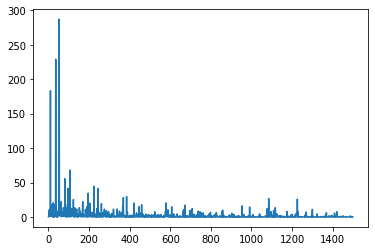

In [29]:
%matplotlib inline

# Baseline Model was trained at 7500 epochs - visualizing only the last 2500 epochs
hist_losses = [float(loss.cpu().detach().numpy()) for loss in hist_loss[:]]
loss_index = [i for i in range(len(hist_losses))]

plt = sns.lineplot(loss_index, hist_losses)
plt

In [18]:
model_save_path = "./models/FreeSolv_baseModel.pth"
torch.save(baseModel, model_save_path)

<h4>Observation from the Loss-Curve</h4>

The Model has a very jittery loss curve with lots of instance of spikes in the loss value over successive iterations.
This could be improved by introducing 'Batch-Normalization' layers in the model-architecture. Also, the model could be made slightly mode complex - by ensuring the node-embedding used for overall graph representation capture most node features by increaing the node-embedding dimensions.

<h4>Evaluate Model performance over the Test data</h4>

In [19]:
# Obtaining The test predictions - Load the Stored baseline model
base_model= torch.load( model_save_path )
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
base_model = base_model.to(device)

In [20]:
test_batch_data = next(iter(test_data_loader))

with torch.no_grad():
    test_batch_data = test_batch_data.to(device)
    prediction, embedding = base_model(test_batch_data.x.float(), test_batch_data.edge_index, test_batch_data.batch)
    df = pd.DataFrame()
    df['y_truth'] = test_batch_data.y.tolist()
    df['y_predict'] = prediction.tolist()

df['y_truth'] = df['y_truth'].apply(lambda row: row[0])
df['y_predict'] = df['y_predict'].apply(lambda row: row[0])
display(df)

C:\Users\palin\Anaconda3\lib\site-packages\torch\nn\functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


,y_truth,y_predict
0,-4.58,-7.874415
1,-11.14,-13.898327
2,-6.62,-7.338458
3,-6.79,-7.102839
4,-6.55,-2.824160
...,...,...
59,-9.37,-8.862805
60,-10.21,-9.717736
61,-4.16,-2.792576
62,-4.40,-8.843917


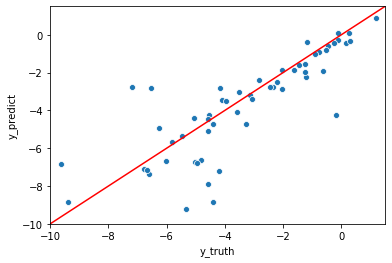

In [21]:
%matplotlib inline

plot=sns.scatterplot(data=df, x="y_truth", y="y_predict")
sns.lineplot([-12, 2], [-12, 2], color="r", dashes=[(2, 2)])
plot.set(xlim=(-10, 1.5))
plot.set(ylim=(-10, 1.5))

plot

<p>
    Since this is a <b>Regression Problem</b> with a single target variable, a model which gives predicted value as close to the <em>target variable</em> as possible is the one which is most desireable. So if we use <b><em>('Ground-Truth', 'Prediction')</em></b> as absicca - ordinate pair to define a data-point & plot it on a cartesian plane i.e. <em>X = "Ground-Truth" | Y = "Prediction"</em> - an ideal model's prediction would return a line <u>close to</u> (<em>but not exactly</em>) <b>X ≈ Y</b> i.e. <b><em>"Prediction" ≈ "Ground-Truth"</em></b>.
</p>
<br>
<b>NOTE: </b>Identity Line, <em><b>X = Y</b></em> is shown in <span style="color: red">red</span>.

In [35]:
def all_data_eval(data, model, device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu") ):
    all_data = DataLoader(data, batch_size=batch_size, shuffle=True)
    # all_data_iter = next(iter(all_data))
    df = {'y_truth': [], 'y_predict': []}
    with torch.no_grad():
        for all_data_batch in all_data:
            all_data_batch = all_data_batch.to(device)
            prediction, embedding = model(all_data_batch.x.float(), all_data_batch.edge_index, all_data_batch.batch)

            df['y_truth']+= all_data_batch.y.tolist()
            df['y_predict']+= prediction.tolist()
    
    df = pd.DataFrame(df)
    df['y_truth'] = df['y_truth'].apply(lambda row: row[0])
    df['y_predict'] = df['y_predict'].apply(lambda row: row[0])
    
    return df

<hr style="border: 3px blue double;"></hr>
<h3>Inspect performance of the Base-line Model over the Entire dataset</h3>

C:\Users\palin\Anaconda3\lib\site-packages\torch_geometric\deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
C:\Users\palin\Anaconda3\lib\site-packages\torch\nn\functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


MSE of the Base Model predictions over the entire dataset: 0.8274045181096339 | Mean Absolute Error: 0.5016675711989496


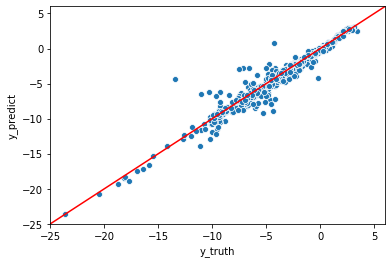

In [28]:
%matplotlib inline

base_pred_df = all_data_eval(data, base_model)

print("MSE of the Base Model predictions over the entire dataset: {} | Mean Absolute Error: {}".format(
                                                                  mean_squared_error(base_pred_df.y_truth, base_pred_df.y_predict),
                                                                  mean_absolute_error(base_pred_df.y_truth, base_pred_df.y_predict)
                                                                                                  )
     )

plot=sns.scatterplot(data=base_pred_df, x="y_truth", y="y_predict")
sns.lineplot([-25, 6], [-25, 6], color="r")
plot.set(xlim=(-25, 6))
plot.set(ylim=(-25, 6))

plot

<h4>Baseline Model Performance Observation -</h4>

The Baseline Model has an <b>MSE</b> of <em>0.83</em> & <b>MAE</b> of <em>0.50</em>. While inspecting the plot with each datapoints' absicca & ordinate values given as<em>x = "Ground-Truth" | y = "Prediction")</em>, it can be inferred that the plot could be more condensed to a straigth line <em>(X=Y)</em> i.e. better predictions could be obtained by building a more complex model.

<h3>Building a Refined Model & Evaluting its Performance</h3>

The Refined Model to be used for predicting Hydration-Free Energy is more complex than the base-line model. It include <em>Batch-Norm</em> layers as well as <em>Graph Attention Convolution</em> Layers.

In [4]:
emb_size = 128
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu:0")
model = freeSolveModel(data.num_features, emb_size)
model = model.to(device)
model

freeSolveModel(
  (in_conv): GCNConv(9, 128)
  (conv1): GATv2Conv(128, 128, heads=4)
  (gnorm): GraphNorm(128)
  (conv2): GCNConv(128, 128)
  (conv3): GATv2Conv(128, 128, heads=2)
  (conv4): GCNConv(128, 128)
  (out): Linear(in_features=256, out_features=1, bias=True)
)

In [5]:
# Summarize the instantiated Model
print("Number of Model Parameters: ", sum(m.numel() for m in model.parameters()))

Number of Model Parameters:  234113


In [6]:
# Use the GPU for Model training if available
# MSE -> Objective / Loss Funciton
loss_function = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0005)
num_epochs = 4000
decay_const = 4.5*num_epochs

lr_schedule = lambda epoch: (np.e)**(-epoch/decay_const)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_schedule)

# Use Data Loader to collate Data into batches
data_size = len(data)
batch_size = 64

# Pass 75% of the data as Train to the Data Loader
train_data_loader = DataLoader(data[:int(data_size * 0.75)], batch_size=batch_size, shuffle=True)

# Pass 25% of the data as Test to the Data Loader
test_data_loader = DataLoader(data[int(data_size * 0.75):], batch_size=batch_size, shuffle=True)


C:\Users\palin\Anaconda3\lib\site-packages\torch_geometric\deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


<h3>Train the compiled Model</h3>

In [7]:
def model_train(train_data_loader, model=model):
    
    for batch_data in train_data_loader:
        
        batch_data=batch_data.to(device)
        optimizer.zero_grad()
        prediction, embedding = model(batch_data.x.float(), batch_data.edge_index, batch_data.batch)
        loss_val = loss_function(prediction, batch_data.y)
        loss_val.backward()
        
        optimizer.step()
        
    return loss_val, embedding

In [26]:
hist_loss = []

for epoch in range(num_epochs):
    loss, _ = model_train(train_data_loader)
    hist_loss.append(loss)
    if epoch%50 == 0:
        print("Completed Epochs: {} -> Loss: {}".format(epoch, loss))
    scheduler.step()

Completed Epochs: 0 -> Loss: 0.031321678310632706
Completed Epochs: 50 -> Loss: 0.01330238115042448
Completed Epochs: 100 -> Loss: 0.028400955721735954
Completed Epochs: 150 -> Loss: 0.023832473903894424
Completed Epochs: 200 -> Loss: 0.014979450963437557


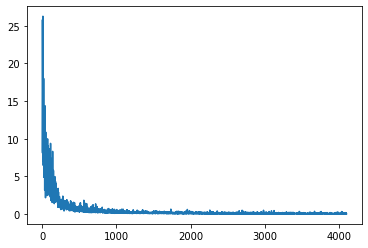

In [28]:
%matplotlib inline

# Inspect the model Loss
hist_losses = [float(loss.cpu().detach().numpy()) for loss in hist_loss]
loss_index = [i for i in range(len(hist_losses))]

plt = sns.lineplot(loss_index, hist_losses)
plt

In [29]:
# save the Model
torch.save(model, "./models/FreeSolv_Model_v5.0.pth")

A more complex model with an appropriate <em>Learning-Rate Schedule</em> results in a very smooth learning curve with gradual decrease in the MSE-loss of the model over successive train epochs. Also the Loss-per-epoch seem to be much lesser than those observed while training the base-line model.

<h3>Evaluate performance of the Trained Model on Test Sample Dataset</h3>

In [30]:
%matplotlib inline

test_batch_data = next(iter(test_data_loader))

with torch.no_grad():
    test_batch_data = test_batch_data.to(device)
    prediction, embedding = model(test_batch_data.x.float(), test_batch_data.edge_index, test_batch_data.batch)
    df = pd.DataFrame()
    df['y_truth'] = test_batch_data.y.tolist()
    df['y_predict'] = prediction.tolist()

df['y_truth'] = df['y_truth'].apply(lambda row: row[0])
df['y_predict'] = df['y_predict'].apply(lambda row: row[0])
#display(df)

print("Range of the Predicted variable -> Min: {} | Max: {}".format(df.y_predict.min(), df.y_predict.max()))
print("Range of the Target variable -> Min: {} | Max: {}".format(df.y_truth.min(), df.y_truth.max()))

C:\Users\palin\Anaconda3\lib\site-packages\torch\nn\functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Range of the Predicted variable -> Min: -17.147245407104492 | Max: 2.6924612522125244
Range of the Target variable -> Min: -17.739999771118164 | Max: 3.430000066757202


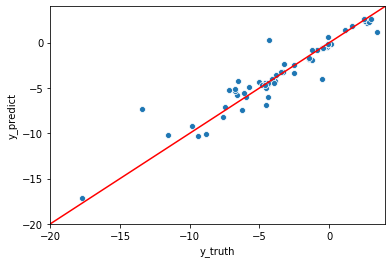

In [33]:
%matplotlib inline

plot=sns.scatterplot(data=df, x="y_truth", y="y_predict")
sns.lineplot([-20, 4], [-20, 4], color="r")
plot.set(xlim=(-20, 4))
plot.set(ylim=(-20, 4))

plot

<hr style="border: 3px double orange;"></hr>
<h3>Inspect the Performance of the model over the Entire Dataset</h3>

C:\Users\palin\Anaconda3\lib\site-packages\torch_geometric\deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
C:\Users\palin\Anaconda3\lib\site-packages\torch\nn\functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Range of the Predicted variable -> Min: -25.637908935546875 | Max: 3.258385419845581
Range of the Target variable -> Min: -25.469999313354492 | Max: 3.430000066757202
MSE of the model predictions over the entire dataset: 0.46582797693446454 | Mean Absolute Error: 0.2876060950886052


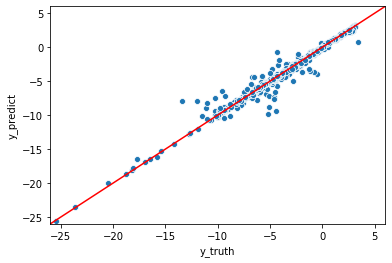

In [39]:
%matplotlib inline

pred_df = all_data_eval(data, model)

print("Range of the Predicted variable -> Min: {} | Max: {}".format(pred_df.y_predict.min(), pred_df.y_predict.max()))
print("Range of the Target variable -> Min: {} | Max: {}".format(pred_df.y_truth.min(), pred_df.y_truth.max()))

# inspect the data plots with absicca as ground-truth values & ordinate as predicted values
plot=sns.scatterplot(data=pred_df, x="y_truth", y="y_predict")
sns.lineplot([-26, 6], [-26, 6], color="r")
plot.set(xlim=(-26, 6))
plot.set(ylim=(-26, 6))

print("MSE of the model predictions over the entire dataset: {} | Mean Absolute Error: {}".format(
                                                                  mean_squared_error(pred_df.y_truth, pred_df.y_predict),
                                                                  mean_absolute_error(pred_df.y_truth, pred_df.y_predict)
                                                                                                  )
     )

plot

<hr style='border: 4px double green'></hr>
<h3>Observation- Refined Model Performance</h3>

The Model performs significantly better than the Baseline with <b>MSE</b> of <em>0.465</em>, which is almost half of that of the baseline model and an <b>MAE</b> of <em>0.287</em>.

The plot with each datapoints' absicca & ordinate values given as<em>x = "Ground-Truth" | y = "Prediction")</em>, is alot more tightly packed and closer to the <b>Identity Line</b> <em style="color: red;">(X=Y)</em> which indicates better performance than the base-line model.